# Importing

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
!pip install scikit-plot
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D # deep learning techniques
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Outline

**1) The first 5 lines in data**

In [10]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/BANGKIT/projek/mental_health.csv')
data.head()

text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1

In [ ]:
!pip install googletrans==3.1.0a0
# Function to translate text from English to Indonesian
from googletrans import Translator

# init the Google API translator
def translate_to_indonesian(text):
    translator = Translator()
    try:
        # use translator.translate() function to translate text
        translation = translator.translate(text, src='en', dest='id')
        # return the translated text
        return translation.text
    except Exception as e:
        # return an error message if there's an error in translation
        return "Error translating text: {}".format(str(e))
# init the Google API translator
translator = Translator()

# set the timeout parameter to 10 seconds
translation = translator.translate('Hello, world!', src='en', dest='id', timeout=10)

# print the translated text
print(translation.text)

In [ ]:
# import pandas library
import pandas as pd

# Apply the translation function to the 'text' column
data['text_indo'] = data['text'].apply(translate_to_indonesian)

# Save the translated DataFrame to a CSV file
data.to_csv('data_terjemahan.csv', index=False)

# Display the DataFrame to check the results
print(data[['text', 'text_indo']])

In [6]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/BANGKIT/projek/data_terjemahan.csv")

**2) Data shape**

In [12]:
print(data.shape)

(27977, 3)


**3) Null in data**

In [13]:
data.isnull().sum()

text         0
label        0
text_indo    0
dtype: int64

**4) The number by labels**

In [14]:
data['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

**5) Bar and Pie plot by '0' and '1'**

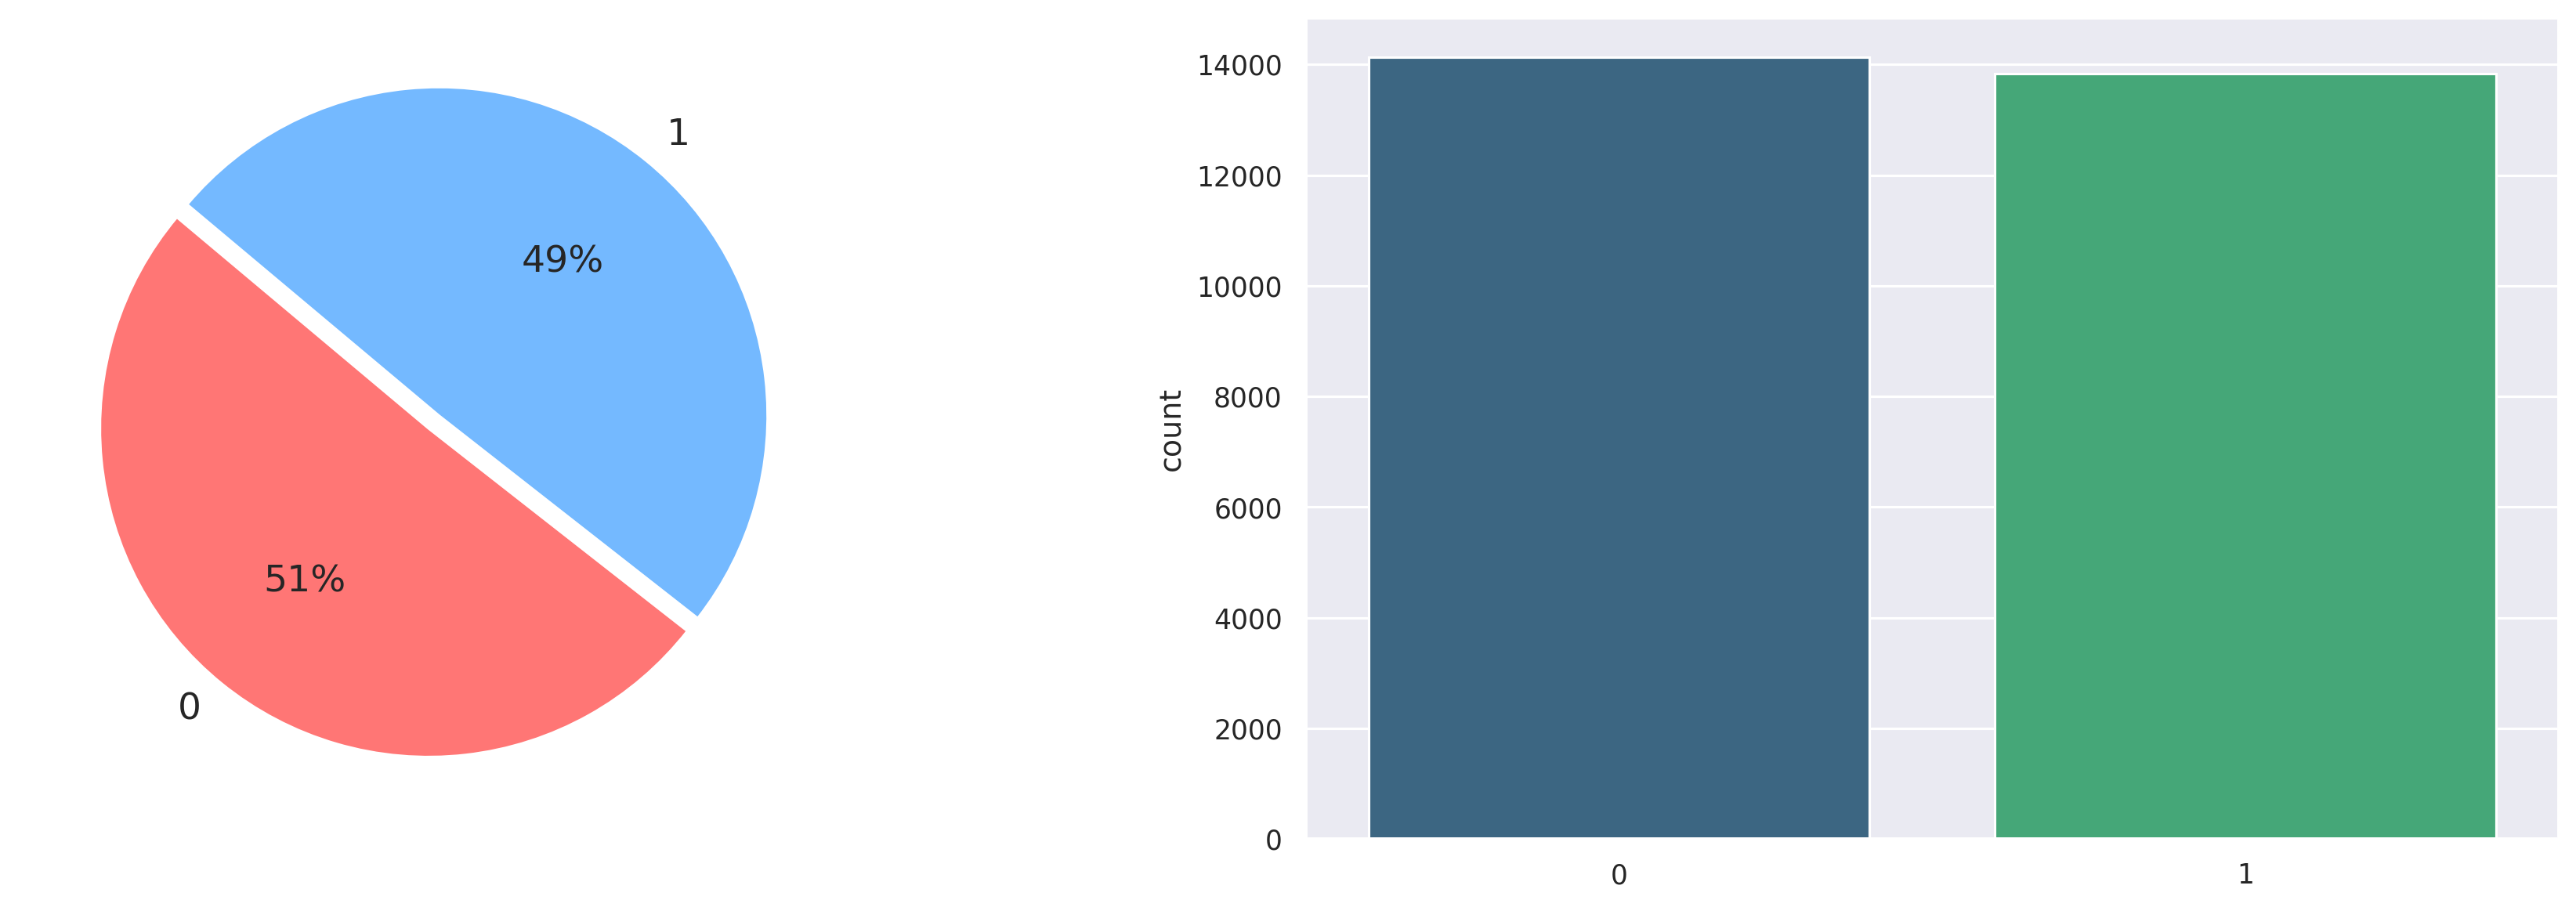

In [15]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

labels = [0, 1]
sizes = [14139, 13838]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['label'].unique(), y = data['label'].value_counts(), palette= 'viridis')

plt.show()

**6) Creating new columns 'Total Words' and 'Total Chars'**

In [16]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

data['Total Words'] = data['text_indo'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text_indo"].apply(count_total_words)

In [17]:
data.describe()

label   Total Words   Total Chars
count  27977.000000  27977.000000  27977.000000
mean       0.494621     79.344855    492.406906
std        0.499980    113.755745    727.829683
min        0.000000      1.000000      2.000000
25%        0.000000     17.000000    105.000000
50%        0.000000     42.000000    254.000000
75%        1.000000     97.000000    595.000000
max        1.000000   2676.000000  25286.000000

**7) Kdeplot by Total Words**

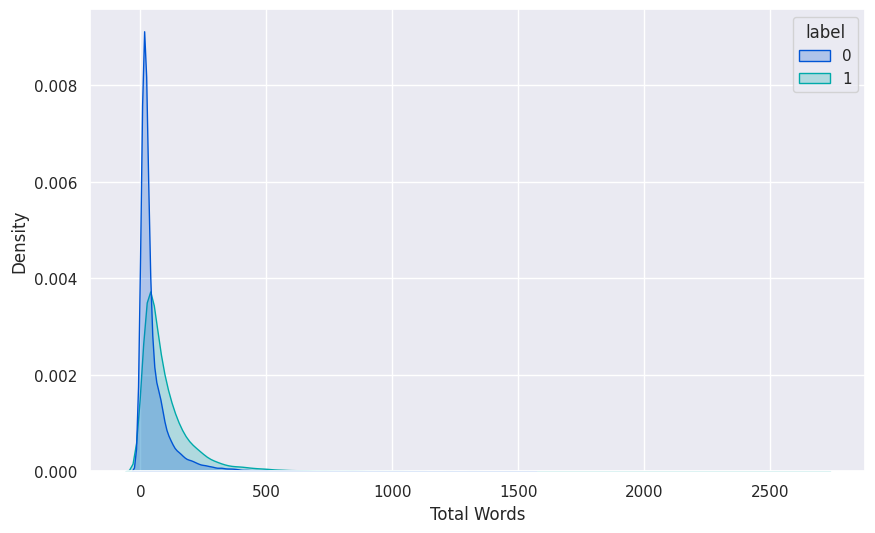

In [18]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

**8) Kdeplot by Total Chars**

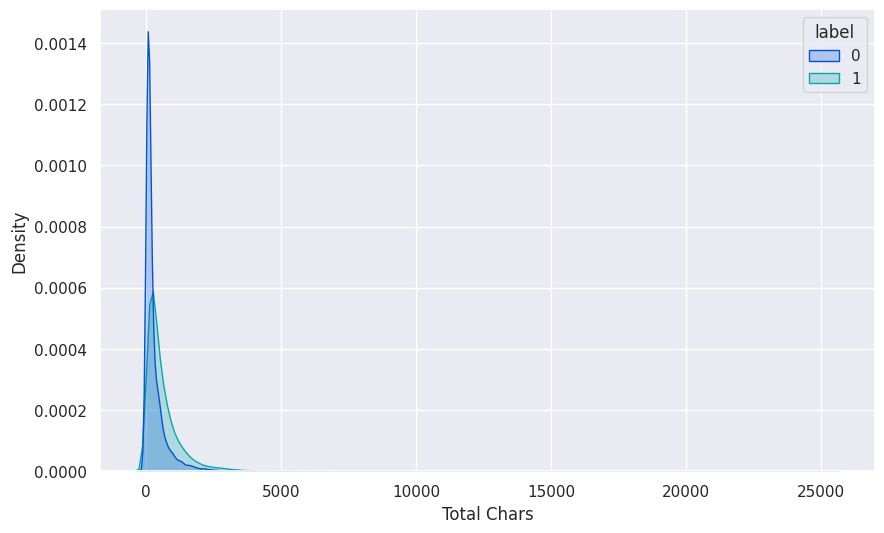

In [19]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

# Text preprocessing

**1) Lowercasing**

In [7]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def convert_lowercase(text):
    text = text.lower()
    return text

data['text_indo'] = data['text_indo'].apply(convert_lowercase)

**2) Removing URLs**

In [8]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

def remove_url(text):
    re_url = re.compile(r'http\S+|www\S+|https\S+')
    return re_url.sub('', text)

data['text_indo'] = data['text_indo'].apply(remove_url)

**3) Removing Punctuations (Tanda Baca)**

In [9]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text_indo'] = data['text_indo'].apply(remove_punc)
data

text  label  \
0      dear american teens question dutch person hear...      0   
1      nothing look forward lifei dont many reasons k...      1   
2      music recommendations im looking expand playli...      0   
3      im done trying feel betterthe reason im still ...      1   
4      worried  year old girl subject domestic physic...      1   
...                                                  ...    ...   
27972  posting everyday people stop caring  religion ...      0   
27973  okay definetly need hear guys opinion ive pret...      0   
27974  cant get dog think ill kill myselfthe last thi...      1   
27975  whats point princess bridei really think like ...      1   
27976  got nudes person might might know snapchat do ...      0   

                                               text_indo  
0      remaja amerika yang terhormat pertanyaan orang...  
1      tak ada harapan hidup tak banyak alasan terus ...  
2      rekomendasi musik yang saya cari perluas dafta...  
3      aku sudah selesai mencoba merasa lebih baik al...  
4      khawatir gadis berusia tahun subjek fisik ruma...  
...                                                  ...  
27972  memposting setiap hari orang berhenti peduli a...  
27973  oke pasti perlu mendengar pendapat temanteman ...  
27974  tidak bisa mendapatkan anjing pikir aku akan b...  
27975  apa gunanya putri pengantin aku benarbenar ber...  
27976  mendapat telanjang orang mungkin mungkin tahu ...  

[27977 rows x 3 columns]

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
data['tokens'] = data['text_indo'].astype(str)
data['tokens'] = data['tokens'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data['tokens'] = data['tokens'].apply(lambda x: [token for token in x if 4 <= len(token) <= 22])
data

text  label  \
0      dear american teens question dutch person hear...      0   
1      nothing look forward lifei dont many reasons k...      1   
2      music recommendations im looking expand playli...      0   
3      im done trying feel betterthe reason im still ...      1   
4      worried  year old girl subject domestic physic...      1   
...                                                  ...    ...   
27972  posting everyday people stop caring  religion ...      0   
27973  okay definetly need hear guys opinion ive pret...      0   
27974  cant get dog think ill kill myselfthe last thi...      1   
27975  whats point princess bridei really think like ...      1   
27976  got nudes person might might know snapchat do ...      0   

                                               text_indo  \
0      remaja amerika yang terhormat pertanyaan orang...   
1      tak ada harapan hidup tak banyak alasan terus ...   
2      rekomendasi musik yang saya cari perluas dafta...   
3      aku sudah selesai mencoba merasa lebih baik al...   
4      khawatir gadis berusia tahun subjek fisik ruma...   
...                                                  ...   
27972  memposting setiap hari orang berhenti peduli a...   
27973  oke pasti perlu mendengar pendapat temanteman ...   
27974  tidak bisa mendapatkan anjing pikir aku akan b...   
27975  apa gunanya putri pengantin aku benarbenar ber...   
27976  mendapat telanjang orang mungkin mungkin tahu ...   

                                                  tokens  
0      [remaja, amerika, yang, terhormat, pertanyaan,...  
1      [harapan, hidup, banyak, alasan, terus, berjal...  
2      [rekomendasi, musik, yang, saya, cari, perluas...  
3      [sudah, selesai, mencoba, merasa, lebih, baik,...  
4      [khawatir, gadis, berusia, tahun, subjek, fisi...  
...                                                  ...  
27972  [memposting, setiap, hari, orang, berhenti, pe...  
27973  [pasti, perlu, mendengar, pendapat, temanteman...  
27974  [tidak, bisa, mendapatkan, anjing, pikir, akan...  
27975  [gunanya, putri, pengantin, benarbenar, berpik...  
27976  [mendapat, telanjang, orang, mungkin, mungkin,...  

[27977 rows x 4 columns]

**4) Removing stopwords (kata tidak relevan)**

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**5) Stemming**

In [13]:
# Stemming
import re

def stem_word(word):
    # Remove inflection suffixes
    word = re.sub(r'(-lah|-ku|-nya|-mu|-kah|-tah|-pun)$', '', word)

    # Remove derivation suffixes
    word = re.sub(r'(-kan|-i|-an)$', '', word)

    # If "-an" has been removed and the word ends with "k", remove "k"
    if word.endswith('k'):
        word = word[:-1]

    return word

data['tokens'] = data['tokens'].apply(lambda x: [stem_word(token) for token in x])


# Join the tokens back into a string
data['processed_text'] = data['tokens'].apply(' '.join)

In [25]:
data

text  label  \
0      dear american teens question dutch person hear...      0   
1      nothing look forward lifei dont many reasons k...      1   
2      music recommendations im looking expand playli...      0   
3      im done trying feel betterthe reason im still ...      1   
4      worried  year old girl subject domestic physic...      1   
...                                                  ...    ...   
27972  posting everyday people stop caring  religion ...      0   
27973  okay definetly need hear guys opinion ive pret...      0   
27974  cant get dog think ill kill myselfthe last thi...      1   
27975  whats point princess bridei really think like ...      1   
27976  got nudes person might might know snapchat do ...      0   

                                               text_indo  \
0      remaja amerika yang terhormat pertanyaan orang...   
1      tak ada harapan hidup tak banyak alasan terus ...   
2      rekomendasi musik yang saya cari perluas dafta...   
3      aku sudah selesai mencoba merasa lebih baik al...   
4      khawatir gadis berusia tahun subjek fisik ruma...   
...                                                  ...   
27972  memposting setiap hari orang berhenti peduli a...   
27973  oke pasti perlu mendengar pendapat temanteman ...   
27974  tidak bisa mendapatkan anjing pikir aku akan b...   
27975  apa gunanya putri pengantin aku benarbenar ber...   
27976  mendapat telanjang orang mungkin mungkin tahu ...   

                                                  tokens  \
0      [remaja, amerika, terhormat, orang, belanda, m...   
1      [harapan, hidup, alasan, berjalan, berjalan, k...   
2      [rekomendasi, musi, cari, perluas, daftar, put...   
3      [selesai, mencoba, alasan, hidup, hancur, bunu...   
4      [khawatir, gadis, berusia, subje, fisi, rumah,...   
...                                                  ...   
27972  [memposting, orang, berhenti, peduli, agama, p...   
27973  [mendengar, pendapat, temanteman, cinta, salah...   
27974  [anjing, pikir, bunuh, pegang, aplikasi, berfu...   
27975  [gunanya, putri, pengantin, benarbenar, berpik...   
27976  [telanjang, orang, snapchat, lakukan, cewe, sn...   

                                          processed_text  
0      remaja amerika terhormat orang belanda mendeng...  
1      harapan hidup alasan berjalan berjalan keesoka...  
2      rekomendasi musi cari perluas daftar putar gen...  
3      selesai mencoba alasan hidup hancur bunuh meni...  
4      khawatir gadis berusia subje fisi rumah tangga...  
...                                                  ...  
27972  memposting orang berhenti peduli agama pribadi...  
27973  mendengar pendapat temanteman cinta salah saha...  
27974  anjing pikir bunuh pegang aplikasi berfungsi d...  
27975  gunanya putri pengantin benarbenar berpikir we...  
27976  telanjang orang snapchat lakukan cewe snap men...  

[27977 rows x 5 columns]

In [15]:
data.to_csv("data text.csv")

# Data Visualization

**1) Word Cloud by label '0'**

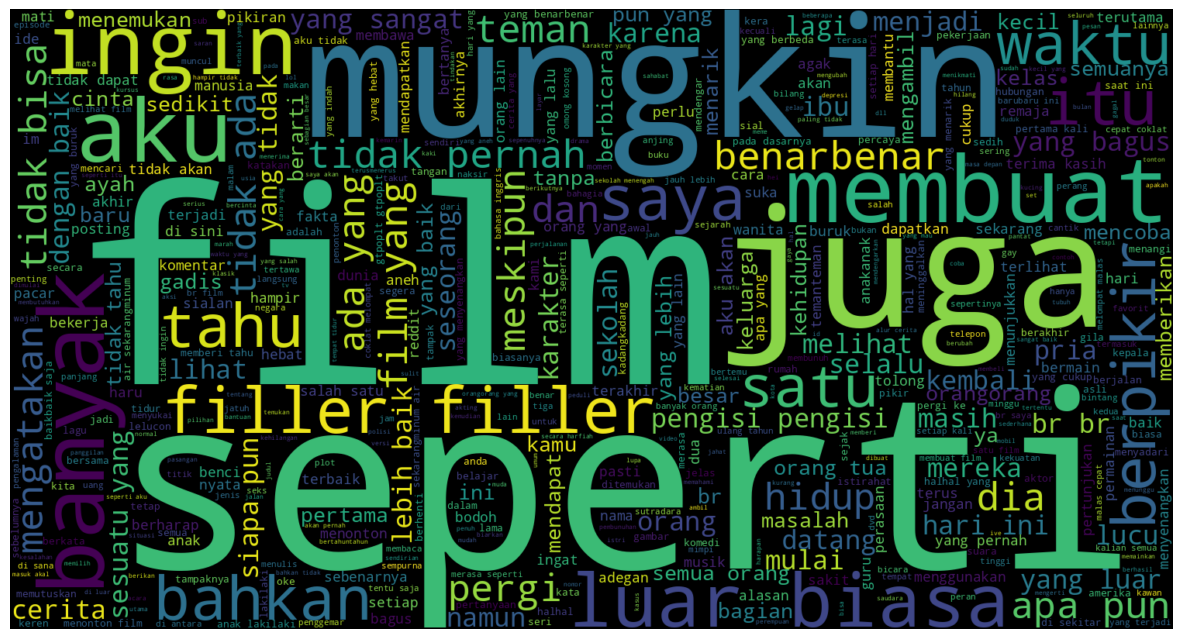

In [28]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

text = " ".join(data[data['label'] == 0]['text_indo'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**2) Word Cloud by label '1'**

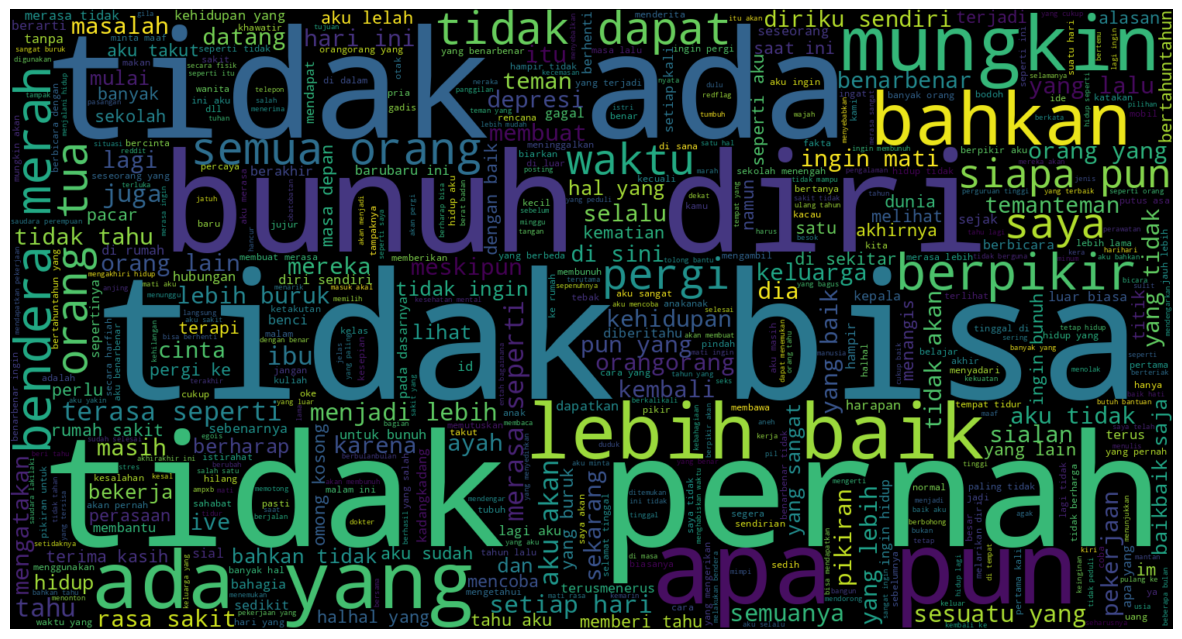

In [29]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

text = " ".join(data[data['label'] == 1]['text_indo'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**3) Word Frequency by label '0'**

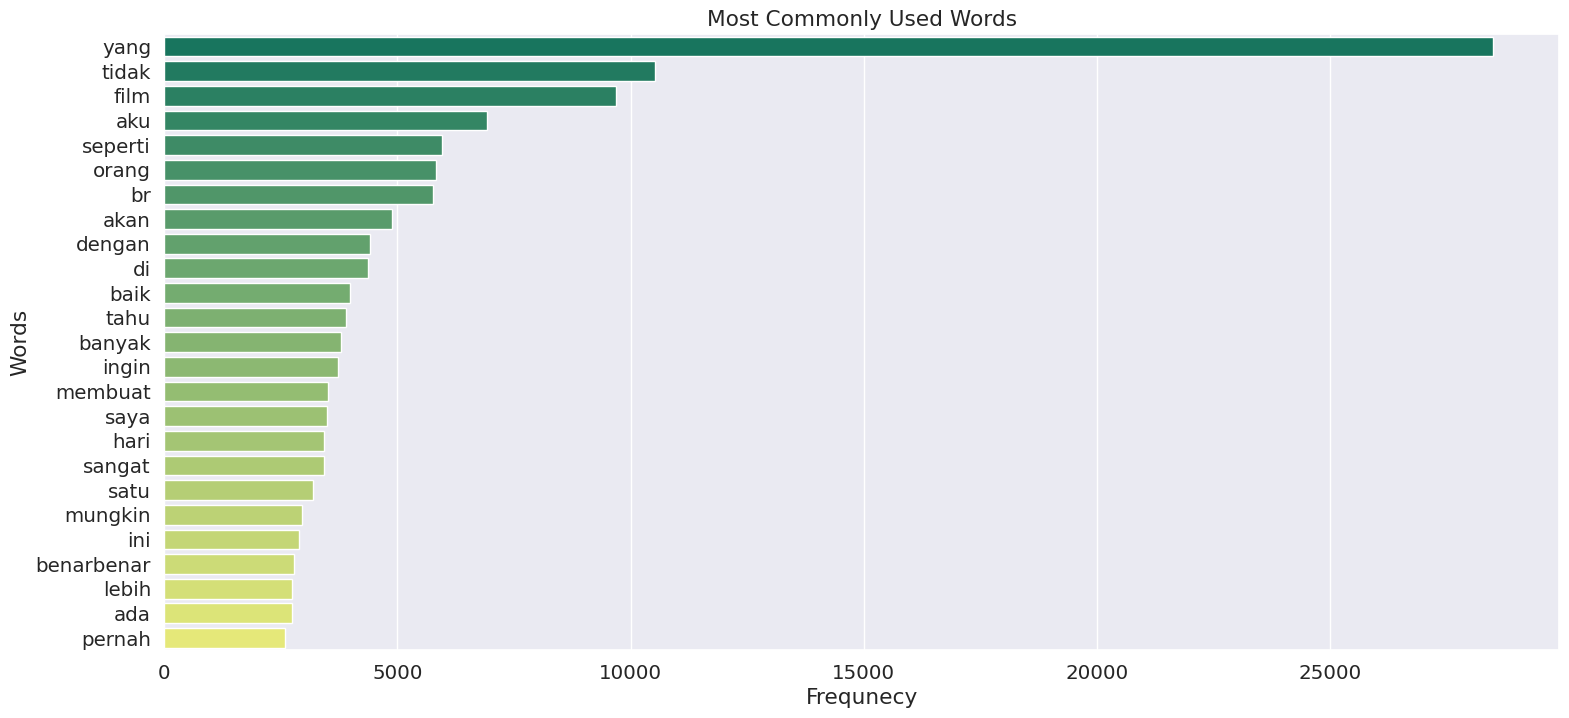

In [30]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

all_spam_words = []
for sentence in data[data['label'] == 0]['text_indo'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

**4) Word Frequency by label '1'**

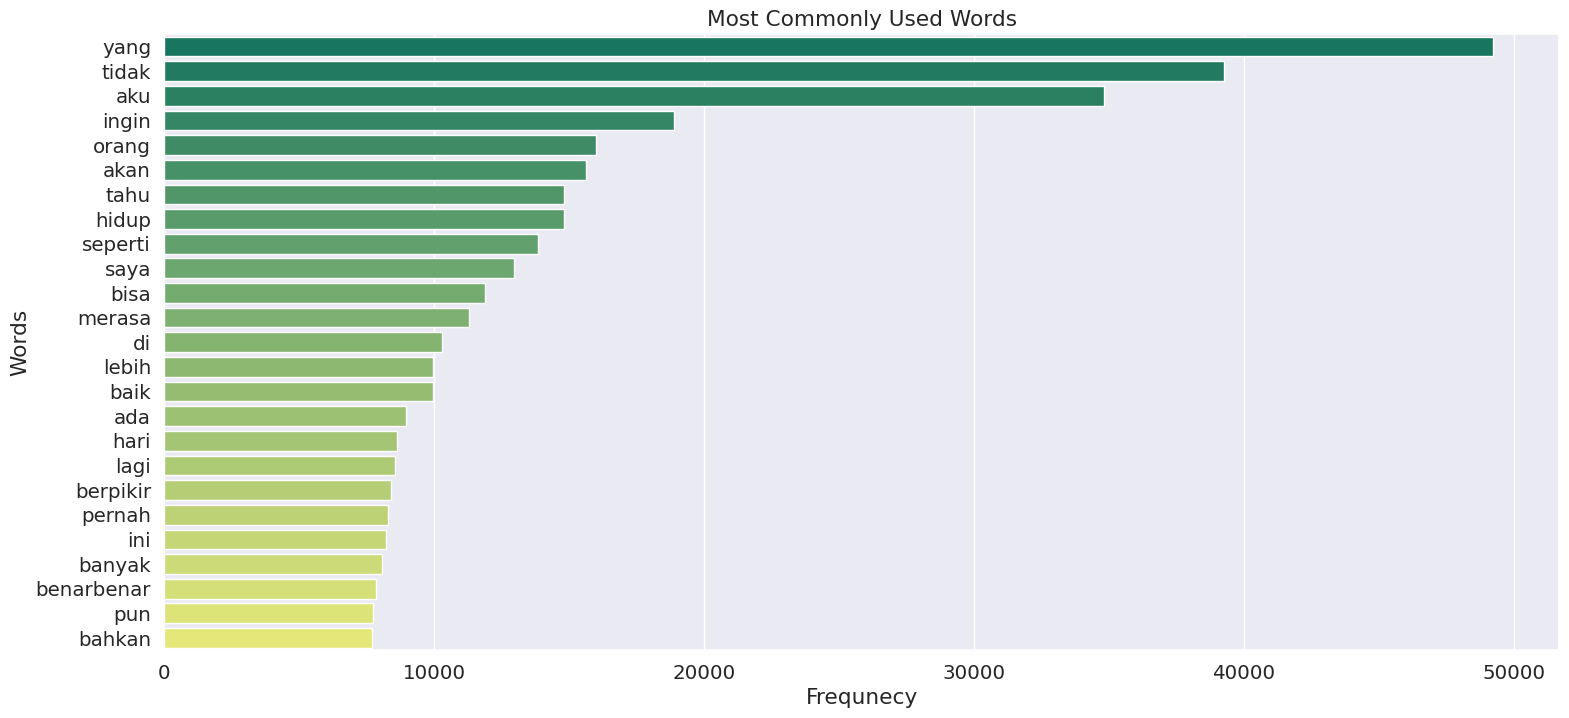

In [31]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

all_spam_words = []
for sentence in data[data['label'] == 1]['text_indo'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

from sklearn.feature_extraction.text import TfidfVectorizer# Modeling

In [28]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Pisahkan fitur (teks) dan label
X = data['processed_text'].values
Y = data['label'].values

# Parameter untuk Tokenizer dan padding
max_words = 10000
max_len = 200

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

# Mengubah teks menjadi urutan angka
sequences = tokenizer.texts_to_sequences(X)

# Padding sequences untuk panjang yang sama
data_pad = pad_sequences(sequences, maxlen=max_len)

# Pembagian data secara manual
X_train = data_pad[:22381]
Y_train = Y[:22381]
X_test = data_pad[22382:]
Y_test = Y[22382:]

# Konversi label ke numpy array dengan tipe float
Y_train = np.array(Y_train, dtype=float)
Y_test = np.array(Y_test, dtype=float)

# Konversi data input dan output ke tipe data yang benar
X_train = X_train.astype(np.int32)
X_test = X_test.astype(np.int32)
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

# Verifikasi tipe data
print(f"Input data type: {X_train.dtype}, {X_test.dtype}")
print(f"Output data type: {Y_train.dtype}, {Y_test.dtype}")

# Definisi model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()

# Latih model
history = model.fit(X_train, Y_train, epochs=30, batch_size=64, validation_split=0.2)
# Evaluasi model pada data pengujian
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")
# Simpan model dalam format H5
model.save("my_model.h5")


Input data type: int32, int32
Output data type: float32, float32


NameError: name 'tf' is not defined

In [33]:
# Prediksi dengan model
predictions = model.predict(X_test)

# Konversi probabilitas prediksi menjadi label biner (0 atau 1)
predicted_labels = (predictions > 0.5).astype(int)

# Hitung akurasi keseluruhan
overall_accuracy = np.mean(predicted_labels == Y_test.reshape(-1, 1))
print(f"Overall Accuracy: {overall_accuracy:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Accuracy: 0.8935


In [34]:
# Output prediksi untuk beberapa contoh
for i in range(len(predicted_labels)):
    print(f"Text: {X[i]} - Predicted Probability: {predictions[i][0]:.4f} - Predicted Label: {predicted_labels[i][0]} - Actual Label: {Y_test[i]}")

Output streaming akan dipotong hingga 5000 baris terakhir.
Text: pantat paus beluga bangun pagi menemukan paus beluga terjeba pantatnya - Predicted Probability: 1.0000 - Predicted Label: 1 - Actual Label: 1.0
Text: suami menikah bertahuntahun bahagia bersamasama kondisi karir mental gelap bertemu pekerjaan menemukan kebahagiaan meninggalkan kerja sukses karir kota menikmati halhal pekerjaan sukses keluarga suami pekerjaan musiman bekas kehidupan kerja sahabat kota perjalanan pergi mencintai menit tugas rekan kerja mencintai bahagia benarbenar mengisi hati bicara telepon kunjungi lihat senang hadiah berdua hidup bermingguminggu kiri berkunjung pekan menemukan energi meletakkan piring kosong mesin pencuci piring menaruh pembungkus sampah kosong meluap daur ulang memilih kotoran anjing halaman kekuatan vakum menghapus counter laundry teman kota pekerjaan suami rekan kerja muda mata mata menghabiskan berjalan minggu anjing bermain halaman rumah berantakan standar lubang depresi pulang ruma

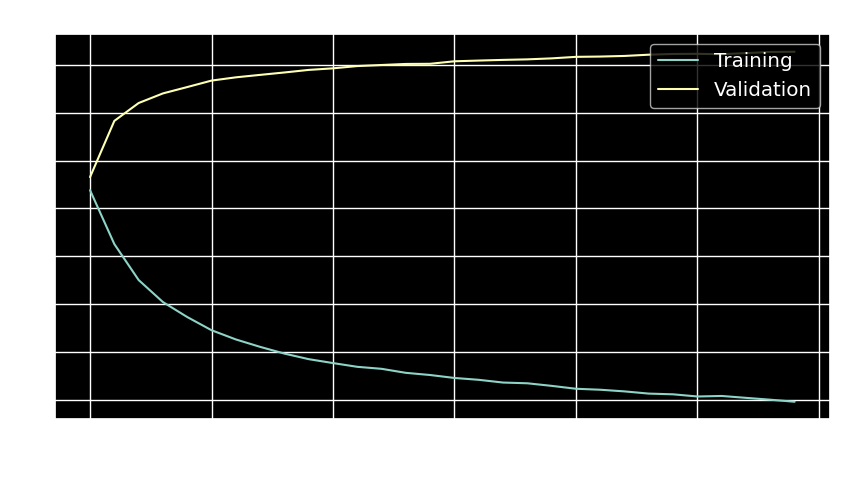

In [35]:
plt.figure(figsize=(10,5))
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

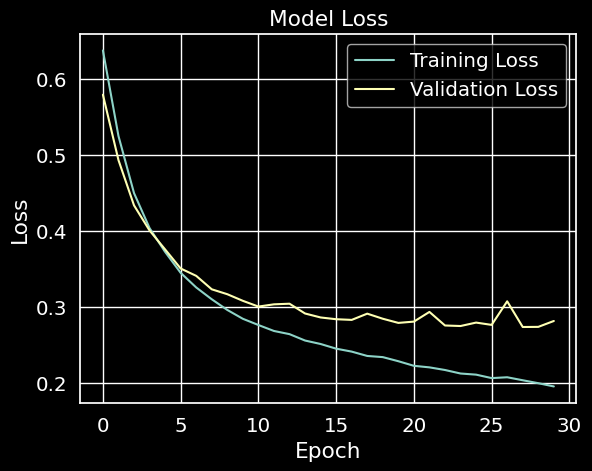

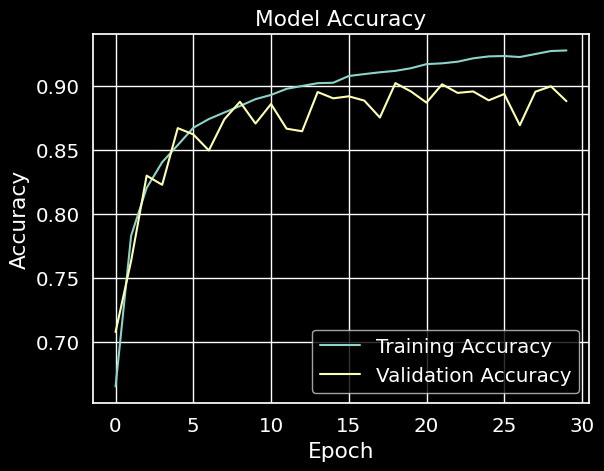

In [36]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [37]:
# Hitung metrik-metrik evaluasi
from sklearn.metrics import classification_report
report = classification_report(Y_test, predicted_labels, target_names=['0', '1'])

# Tampilkan laporan evaluasi
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2827
           1       0.94      0.84      0.89      2768

    accuracy                           0.89      5595
   macro avg       0.90      0.89      0.89      5595
weighted avg       0.90      0.89      0.89      5595



In [2]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

NameError: name 'Tokenizer' is not defined

In [39]:
tokenizer.word_index

{'orang': 1,
 'hidup': 2,
 'benarbenar': 3,
 'berpikir': 4,
 'film': 5,
 'pergi': 6,
 'mencoba': 7,
 'sakit': 8,
 'buru': 9,
 'teman': 10,
 'mati': 11,
 'kehidupan': 12,
 'pekerjaan': 13,
 'orangorang': 14,
 'sekolah': 15,
 'bunuh': 16,
 'rumah': 17,
 'keluarga': 18,
 'kali': 19,
 'depresi': 20,
 'berbicara': 21,
 'halhal': 22,
 'cinta': 23,
 'pikiran': 24,
 'malam': 25,
 'tidur': 26,
 'membantu': 27,
 'menemukan': 28,
 'berharap': 29,
 'takut': 30,
 'peduli': 31,
 'merah': 32,
 'berhenti': 33,
 'bertahuntahun': 34,
 'bendera': 35,
 'benci': 36,
 'alasan': 37,
 'bagus': 38,
 'ayah': 39,
 'temanteman': 40,
 'dunia': 41,
 'mengambil': 42,
 'bantuan': 43,
 'bahagia': 44,
 'membunuh': 45,
 'sialan': 46,
 'ana': 47,
 'lihat': 48,
 'lelah': 49,
 'salah': 50,
 'perasaan': 51,
 'tolong': 52,
 'bicara': 53,
 'kehilangan': 54,
 'gadis': 55,
 'terbai': 56,
 'keras': 57,
 'menangis': 58,
 'pria': 59,
 'pacar': 60,
 'hati': 61,
 'lakilaki': 62,
 'minggu': 63,
 'kasih': 64,
 'bodoh': 65,
 'hubungan'

In [37]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import load_model
model = load_model("/content/my_model.h5")
def stem_word(word):
    # Remove inflection suffixes
    word = re.sub(r'(-lah|-ku|-nya|-mu|-kah|-tah|-pun)$', '', word)

    # Remove derivation suffixes
    word = re.sub(r'(-kan|-i|-an)$', '', word)

    # If "-an" has been removed and the word ends with "k", remove "k"
    if word.endswith('k'):
        word = word[:-1]

    return word
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stopword = nltk.corpus.stopwords.words('indonesian')
    tokens = [word for word in tokens if word not in stopword]

    # Stemming
    tokens = [stem_word(token) for token in tokens]

    # Join tokens back to string
    processed_text = ' '.join(tokens)

    return processed_text

# Inisialisasi tokenizer
max_words = 10000
max_len = 200
#tokenizer = Tokenizer(num_words=max_words)

# Definisikan fungsi prediksi kelas
def predict_class(model, tokenizer, text):
    # Memuat kelas label (gantilah dengan kelas label Anda)
    list_labels = ["0", "1"]

    # Tokenisasi teks
    sequences = tokenizer.texts_to_sequences([text])
    print(sequences)
    # Padding sequences untuk panjang yang sama
    data_pad = pad_sequences(sequences, maxlen=max_len)
    # Prediksi dengan model
    prediction = model.predict(data_pad)[0]

    # Ambil indeks kelas dengan probabilitas tertinggi
    predicted_index = np.argmax(prediction)
    # Buat dictionary hasil prediksi
    result = {list_labels[predicted_index]: prediction[predicted_index]}
    return (prediction > 0.5).astype(int)[0],prediction[0]

# Contoh teks yang ingin Anda prediksi
text_to_predict = "lebih baik pergi daripada hidup sendiri sudah capek apalagi orang tua sangat mendesak"

# Preprocess teks
preprocessed_text = preprocess_text(text_to_predict)

# Prediksi kelas
prediction_result = predict_class(model, tokenizer, preprocessed_text)
print(prediction_result)


[[6, 2, 1663, 1, 1692]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(1, 0.5794686)


In [41]:
import pickle
# Simpan tokenizer
tokenizer_path = "save_tokenizer.pkl"
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Kemudian, saat Anda memuat kembali tokenizer:
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)


In [ ]:
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("my_model.h5")

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import numpy as np
import tensorflow as tf

# Load model
interpreter = tf.lite.Interpreter(model_path="/content/my_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
list_labels = list(np.array([0, 1]))
# Define function to predict class
def predict_class(interpreter, tokenizer, text):
    # Tokenize text
    sequences = tokenizer.texts_to_sequences([text])
    data_pad = pad_sequences(sequences, maxlen=max_len)

    # Set input tensor
    input_data = np.array(data_pad, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Extract prediction
    prediction = output_data[0]
    predicted_index = np.argmax(prediction)
    result = {list_labels[predicted_index]: prediction[predicted_index]}
    return result

# Example text to predict
text_to_predict = 'ingin laut ingin menenggelamkan orangtemanku ingin bunuh diri melelahkan ya butuh bantuan dukungan selalu mengharapkan mendapatkannya bicara orang tua dapatkan terapis menelepon hotline dump sialan setiap kali benar-benar teman yang akan mendengarkan aku mulai mengerti mengapa perawatan tidak bisa menangani praktis minggu kelelahan bahkan seharusnya katakan padanya semuanya mengeluh benar ya seseorang suka seseorang peduli apakah hidup mati pengecualian orang mungkin ya gendut jelek ya tidak mampu menjaga bahkan bodoh upah minimal pekerjaan ya gagal sekolah ya hidup sia-sia tak berarti tidak ada apa pun yang mengirimkan foto pistol memberitahu otak akan dinding membuat merasa seperti sandera tak berdaya takut pergi ingin bicara dengarkan rekaman rusak cerita malam sampai dia cukup mabuk pingsan jam tidur mampu dia menganggur memberikan sekolah sialan aku tangan fungsi bangun dengan baik jam tidur semua berpikir aku mencapai titik segera kelelahan lelah kurang tidur katakan pergi itu hampir yakin akan pilihan terbaik dia apa pun memperbaiki situasi mengubah apa pun Bikin depresi tak peduli lagi mengikis tetap kewarasan'

# Preprocess text
preprocessed_text = preprocess_text(text_to_predict)

# Predict class
prediction_result = predict_class(interpreter, tokenizer, preprocessed_text)
print(prediction_result)


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras '/content/my_model.h5' my_dir